# DNS Kernel Comparison

This notebook provides a comprehensive comparison between DNS (Direct Numerical Simulation) collision kernels and the model predictions using the `particula` package. It serves as an introduction for new users to understand how DNS data and coagulation kernels are utilized in atmospheric and aerosol science.

## Introduction to DNS and Coagulation Kernels

**Direct Numerical Simulation (DNS)** is a computational method that solves the Navier-Stokes equations directly, without any turbulence models, to simulate turbulent flows with all scales of motion resolved. This allows for detailed investigation of particle interactions in turbulent flows, which is essential for understanding processes like coagulation.

**Coagulation Kernels** quantify the rate at which particles collide and potentially coalesce in a medium, often influenced by factors like turbulence, Brownian motion, and external forces such as gravity. Understanding these kernels is crucial for predicting particle size distributions in aerosols, clouds, and other particulate systems.

In this notebook, we replicate and compare the collision kernels from the DNS data as presented in Figure 18a of the following reference:

**Reference:**
Ayala, O., Rosa, B., & Wang, L. P. (2008). *Effects of turbulence on the geometric collision rate of sedimenting droplets. Part 2. Theory and parameterization*. New Journal of Physics, 10. https://doi.org/10.1088/1367-2630/10/7/075016

<details> <summary>▶️ Install Particula</summary>
try:
    import google.colab
except ImportError:
    # not Colab → do nothing
    pass
else:
    # in Colab → install quietly
    get_ipython().system("pip install particula[extra] --quiet")
</details>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import particula as par

from particula.dynamics import (
    get_turbulent_dns_kernel_ao2008,
)
from particula.dynamics.coagulation.turbulent_dns_kernel.radial_velocity_module import (
    get_radial_relative_velocity_dz2002,
)
from particula.dynamics.coagulation.turbulent_dns_kernel.g12_radial_distribution_ao2008 import (
    get_g12_radial_distribution_ao2008,
)
from particula.dynamics.coagulation.turbulent_dns_kernel.sigma_relative_velocity_ao2008 import (
    get_relative_velocity_variance,
)
from particula.util import get_unit_conversion
from particula.util.constants import STANDARD_GRAVITY

# Case 1: Comparison of Collision Kernel

# DNS dynamic collision kernel and predicted collision kernel of
# sedimenting droplets in a turbulent ﬂow. (a) a1 = 30µm, Rλ = 72.41 and  =
# 400 cm2 s−3

# Dataset for kernel comparison
data = np.array(
    [
        [10.06067961, 0.000581818],
        [14.97572816, 0.000654545],
        [19.8907767, 0.000642424],
        [25.1092233, 0.000581818],
        [27.53640777, 0.000484848],
        [29.96359223, 0.000315152],
        [32.51213592, 0.000666667],
        [40.03640777, 0.001963636],
        [50.04854369, 0.004618182],
        [60, 0.009127273],
    ]
)

## Define Particle Radii and Physical Parameters

In this section, we set up the range of particle radii and other essential physical parameters required for the collision kernel calculations.

- **Particle Radii**: We consider particles ranging from 1 µm to 60 µm in radius, which are typical sizes for cloud droplets.
- **Turbulent Dissipation Rate (ε)**: Represents the rate at which turbulent kinetic energy is converted into thermal energy. A higher ε indicates more vigorous turbulence, affecting particle collision rates.
- **Reynolds Number (Reλ)**: The Reynolds number based on the Taylor microscale, indicating the intensity of turbulence in the flow.
- **Particle and Fluid Densities**: Densities of the particles and the surrounding fluid (air) are necessary for calculating settling velocities and inertia times.
- **Temperature**: The ambient temperature affects fluid properties like viscosity and mean free path.
These parameters are critical for simulating realistic atmospheric conditions and ensuring that the model predictions are comparable with DNS data.

In [14]:
particle_radius = np.linspace(1e-6, 60e-6, 200)  # From 1 µm to 60 µm

# Convert turbulent dissipation from cm²/s³ to m²/s³
turbulent_dissipation = 400 * get_unit_conversion("cm^2/s^3", "m^2/s^3")
reynolds_lambda = 72.41  # Example value

## Define the Kernel Calculation Function

This function calculates the collision kernel values using the specified parameters and the `particula` package implementations. This are the full steps of the function. Use this as a reference to understand how the kernels are calculated.

In [15]:
def kernel_calc(particle_radius, turbulent_dissipation, reynolds_lambda):
    # Define constants and parameters
    temperature = 273  # Temperature in Kelvin
    particle_density = 1000  # Particle density in kg/m³
    fluid_density = 1.0  # Fluid (air) density in kg/m³

    # 1. Basic fluid par.particles
    dynamic_viscosity = par.gas.get_dynamic_viscosity(temperature)
    kinematic_viscosity = par.gas.get_kinematic_viscosity(
        dynamic_viscosity=dynamic_viscosity, fluid_density=fluid_density
    )
    mean_free_path = par.gas.get_molecule_mean_free_path(
        temperature=temperature, dynamic_viscosity=dynamic_viscosity
    )

    # 2. Slip correction factors
    knudsen_number = par.particles.get_knudsen_number(
        mean_free_path=mean_free_path, particle_radius=particle_radius
    )
    slip_correction_factor = par.particles.get_cunningham_slip_correction(
        knudsen_number
    )

    # Handle radius addition properly for arrays
    collisional_radius = (
        particle_radius[:, np.newaxis] + particle_radius[np.newaxis, :]
        if isinstance(particle_radius, np.ndarray)
        else 2.0 * particle_radius
    )

    # 3. Particle inertia and settling velocity
    particle_inertia_time = par.particles.get_particle_inertia_time(
        particle_radius=particle_radius,
        particle_density=particle_density,
        fluid_density=fluid_density,
        kinematic_viscosity=kinematic_viscosity,
    )
    particle_settling_velocity = (
        par.particles.get_particle_settling_velocity_with_drag(
            particle_radius=particle_radius,
            particle_density=particle_density,
            fluid_density=fluid_density,
            dynamic_viscosity=dynamic_viscosity,
            slip_correction_factor=slip_correction_factor,
            re_threshold=0.1,
        )
    )

    # 4. Turbulence scales
    fluid_rms_velocity = par.gas.get_fluid_rms_velocity(
        re_lambda=reynolds_lambda,
        kinematic_viscosity=kinematic_viscosity,
        turbulent_dissipation=turbulent_dissipation,
    )
    taylor_microscale = par.gas.get_taylor_microscale(
        fluid_rms_velocity=fluid_rms_velocity,
        kinematic_viscosity=kinematic_viscosity,
        turbulent_dissipation=turbulent_dissipation,
    )
    eulerian_integral_length = par.gas.get_eulerian_integral_length(
        fluid_rms_velocity=fluid_rms_velocity,
        turbulent_dissipation=turbulent_dissipation,
    )
    lagrangian_integral_time = par.gas.get_lagrangian_integral_time(
        fluid_rms_velocity=fluid_rms_velocity,
        turbulent_dissipation=turbulent_dissipation,
    )

    # 6. Additional turbulence-based quantities
    kolmogorov_time = par.gas.get_kolmogorov_time(
        kinematic_viscosity=kinematic_viscosity,
        turbulent_dissipation=turbulent_dissipation,
    )
    stokes_number = par.particles.get_stokes_number(
        particle_inertia_time=particle_inertia_time,
        kolmogorov_time=kolmogorov_time,
    )
    kolmogorov_length_scale = par.gas.get_kolmogorov_length(
        kinematic_viscosity=kinematic_viscosity,
        turbulent_dissipation=turbulent_dissipation,
    )
    reynolds_lambda = par.particles.get_particle_reynolds_number(
        particle_radius=particle_radius,
        particle_velocity=particle_settling_velocity,
        kinematic_viscosity=kinematic_viscosity,
    )
    normalized_accel_variance = (
        par.gas.get_normalized_accel_variance_ao2008(
            re_lambda=reynolds_lambda,
        )
    )
    kolmogorov_velocity = par.gas.get_kolmogorov_velocity(
        kinematic_viscosity=kinematic_viscosity,
        turbulent_dissipation=turbulent_dissipation,
    )
    lagrangian_taylor_microscale_time = (
        par.gas.get_lagrangian_taylor_microscale_time(
            kolmogorov_time=kolmogorov_time,
            re_lambda=reynolds_lambda,
            accel_variance=normalized_accel_variance,
        )
    )

    # 5. Relative velocity variance
    velocity_dispersion = get_relative_velocity_variance(
        fluid_rms_velocity=fluid_rms_velocity,
        collisional_radius=collisional_radius,
        particle_inertia_time=particle_inertia_time,
        particle_velocity=np.abs(particle_settling_velocity),
        taylor_microscale=taylor_microscale,
        eulerian_integral_length=eulerian_integral_length,
        lagrangian_integral_time=lagrangian_integral_time,
        lagrangian_taylor_microscale_time=lagrangian_taylor_microscale_time,
    )

    # Compute Kernel Values
    kernel_values = get_turbulent_dns_kernel_ao2008(
        particle_radius=particle_radius,
        velocity_dispersion=np.abs(velocity_dispersion),
        particle_inertia_time=particle_inertia_time,
        stokes_number=stokes_number,
        kolmogorov_length_scale=kolmogorov_length_scale,
        reynolds_lambda=reynolds_lambda,
        normalized_accel_variance=normalized_accel_variance,
        kolmogorov_velocity=kolmogorov_velocity,
        kolmogorov_time=kolmogorov_time,
    )

    return kernel_values


# Compute Kernel Values
kernel_values = kernel_calc(
    particle_radius, turbulent_dissipation, reynolds_lambda
)

## Compute Kernel via System State

The previous method can be a bit much to put in code. We have implemented the same code above in a `get_kernel_ao2008_via_system_state` function. This function takes the system state directly and computes the kernel. This is a more direct way to compute the kernel, and hides the complexity of the previous method.


In [16]:
kernel_via_system_state = par.dynamics.get_turbulent_dns_kernel_ao2008_via_system_state(
    particle_radius=particle_radius,
    particle_density=1000,
    fluid_density=1.0,
    temperature=273,
    turbulent_dissipation=400 * get_unit_conversion("cm^2/s^3", "m^2/s^3"),
    re_lambda=72.41,
    relative_velocity=0.0,
)

## Plot the Comparison Graph

We plot the DNS data and their corresponding model predictions on the same graph for easy comparison.

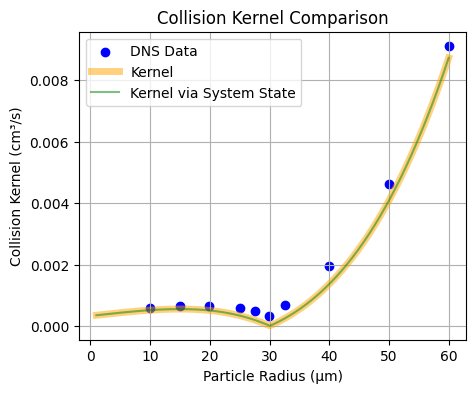

In [17]:
index = np.argmin(np.abs(particle_radius - 30e-6))

fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data[:, 0], data[:, 1], label="DNS Data", color="blue")
ax.plot(
    particle_radius * 1e6,
    kernel_values[:, index] * get_unit_conversion("m^3/s", "cm^3/s"),
    label="Kernel",
    color="orange",
    alpha=0.5,
    linewidth=5,
)
ax.plot(
    particle_radius * 1e6,
    kernel_via_system_state[:, index] * get_unit_conversion("m^3/s", "cm^3/s"),
    label="Kernel via System State",
    color="green",
    alpha=0.5,
)
ax.set_xlabel("Particle Radius (µm)")
ax.set_ylabel("Collision Kernel (cm³/s)")
plt.title("Collision Kernel Comparison")
ax.legend()
ax.grid(True)
plt.show()

## Calculate Percent Error

We calculate the percent error between the model predictions and the DNS data to assess the accuracy of our implementation.
 Extract DNS data

In [18]:
dns_radii = data[:, 0] * 1e-6  # Convert from µm to meters
dns_kernels = data[:, 1] * get_unit_conversion("cm^3/s", "m^3/s")

# Interpolate model predictions at DNS radii
from scipy.interpolate import interp1d

interpolator = interp1d(
    particle_radius,
    kernel_values[:, np.argmin(np.abs(particle_radius - 30e-6))],
    kind="linear",
    fill_value="extrapolate",
)
model_kernels_at_dns = interpolator(dns_radii)

# Calculate percent error
percent_errors = (model_kernels_at_dns - dns_kernels) / dns_kernels * 100

## Display Comparison Table

We display the DNS data, model predictions, and percent errors in a table for comparison.

In [19]:
import pandas as pd

results_df = pd.DataFrame(
    {
        "Radius (µm)": data[:, 0],
        "DNS Kernel (cm³/s)": data[:, 1],
        "Model Kernel (cm³/s)": model_kernels_at_dns
        * get_unit_conversion("m^3/s", "cm^3/s"),
        "Percent Error (%)": percent_errors,
    }
)

display(results_df)

,Radius (µm),DNS Kernel (cm³/s),Model Kernel (cm³/s),Percent Error (%)
0,10.060680,0.000582,0.000515,-11.436263
1,14.975728,0.000655,0.000550,-16.026446
2,19.890777,0.000642,0.000505,-21.319316
3,25.109223,0.000582,0.000331,-43.042365
4,27.536408,0.000485,0.000192,-60.360381
5,29.963592,0.000315,0.000014,-95.676393
6,32.512136,0.000667,0.000241,-63.882460
7,40.036408,0.001964,0.001372,-30.128723
8,50.048544,0.004618,0.004102,-11.173559
9,60.000000,0.009127,0.008730,-4.348430


## Summary

This notebook compares DNS collision kernels with model predictions using the Ayala and Rosa (2008) model implemented in the `particula` package. It provides a detailed analysis of the collision kernels and their application in atmospheric and aerosol science. The comparison graph and table help visualize the differences between DNS data and model predictions, along with the corresponding percent errors. This serves as a useful guide for understanding and utilizing collision kernels in turbulent flows and particulate systems.

## Results

- The notebook computes and compares DNS collision kernels with model predictions.
- Percent error shows varying accuracy, But consistent with the accuracy reported in the original paper.
- Graph and table visualize differences between DNS data and model predictions.

This notebook guides understanding and comparing DNS collision kernels and model predictions in atmospheric and aerosol science.